## load libraries

In [1]:
''' import compute modules and functions '''

import time
import torch
import numpy as np
from tutorial_metarl.task import BernoulliBandit
from tutorial_metarl.model import LSTM as Agent
from tutorial_metarl.model.utils import compute_returns, compute_a2c_loss 
from tutorial_metarl.model.utils import get_reward_mab, one_hot_embedding, _input

## setup Meta-RL environment, agent and trainer

In [2]:
''' set seed for reporducibility '''

seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [82]:
'''init task'''

PROBS = [0.1, 0.2, 0.8, 0.9] 
n_cues = len(PROBS)
task = BernoulliBandit(seed=seed_val, probs=PROBS)
n_arms = task.num_arms

In [4]:
'''init model'''

# LSTM params
dim_hidden = 48 # number of hiden units
dim_output = n_arms # dimension output
estimate_Qvals = True # predict q-values or not

agent = Agent(dim_hidden, dim_output, seed=seed_val, q_est=estimate_Qvals)

In [5]:
''' init trainer'''

learning_rate = 1e-3 # learning rate
n_epochs = 100  # number of epochs
n_episodes = 200 # number of episodes
n_trials = 100  # number of trials
beta_e = 0.05  # weight for entropy loss
beta_v = 0.50  # weight for value loss
gamma = 0.8    # discount factor
normalize_return = True

optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [6]:
''' create logs '''

log_cumreward = np.zeros((n_epochs, n_cues, n_episodes))
log_loss_value = np.zeros((n_epochs, n_cues, n_episodes))
log_loss_policy = np.zeros((n_epochs, n_cues, n_episodes))
log_loss_entropy = np.zeros((n_epochs, n_cues, n_episodes))
log_rewards = np.zeros((n_epochs, n_cues, n_episodes, n_trials))
log_actions = np.zeros((n_epochs, n_cues, n_episodes, n_trials))
log_regret = np.zeros((n_epochs, n_cues, n_episodes, n_trials))

## train agent

In [ ]:
# loop over epoch
for i in range(n_epochs):
    time_start = time.time()

    # train different episodes of task
    for m in range(n_episodes): 
        
        # sample structure
        prob = np.random.choice(PROBS)
        c_indx = np.where(prob==PROBS)[0].squeeze()
        Y = task.sample(num_episodes=n_trials, prob=prob)
        
        # prealloc
        cumulative_reward = 0
        probs, rewards, values, entropys = [], [], [], []
        h_t, c_t = agent.get_init_states()
        a_t = None
        r_t = Y[0].mean()

        # loop over time, for one training example
        for t in range(n_trials):
    
            # recurrent computation at time t
            one_hot_a_t = one_hot_embedding(a_t, n_arms)
            x_t = _input(one_hot_a_t, r_t, t)
            output_t, cache_t = agent(x_t, h_t, c_t)
            a_t, log_prob_a_t, v_t, _, _ = output_t
            _, _, _, _, p_at = cache_t
            
            # compute entropy
            entropy = -torch.sum(torch.log(p_at)*p_at)

            # compute immediate reward
            r_t = get_reward_mab(a_t, Y[t])

            # log
            probs.append(log_prob_a_t)
            rewards.append(r_t)
            entropys.append(entropy)
            values.append(v_t) 
            cumulative_reward += r_t
            log_actions[i, c_indx, m, t] = a_t.item()
            log_regret[i, c_indx, m, t] = 1. - r_t
            log_rewards[i, c_indx, m, t] = r_t
        
        # compute loss
        returns = compute_returns(rewards, gamma=gamma, normalize=normalize_return)
        loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
        loss_entropy = torch.stack(entropys).sum()
        loss = loss_policy + beta_v*loss_value - beta_e*loss_entropy
        
        # gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        log_cumreward[i, c_indx, m] = cumulative_reward / n_trials
        log_loss_value[i, c_indx, m] += loss_value.item() / n_trials
        log_loss_policy[i, c_indx, m] += loss_policy.item() / n_trials
        log_loss_entropy[i, c_indx, m] += loss_entropy.item() / n_trials

    # print out training status
    time_end = time.time()
    run_time = time_end - time_start
    print('Epoch %3d | Mean. Rewaard = %.2f | loss: val = %.2f, pol = %.2f, entropy = %.2f | time = %.2f' %
    (i, log_cumreward[i].sum()/n_episodes, log_loss_value[i].sum()/n_episodes, log_loss_policy[i].sum()/n_episodes, log_loss_entropy[i].sum()/n_episodes, run_time))

Epoch   0 | return = 0.11 | loss: val = 0.45, pol = 0.24, entropy = 0.57 | time = 54.77
Epoch   1 | return = 0.13 | loss: val = 0.41, pol = 0.03, entropy = 0.66 | time = 55.09
Epoch   2 | return = 0.13 | loss: val = 0.40, pol = -0.13, entropy = 0.65 | time = 54.82
Epoch   3 | return = 0.12 | loss: val = 0.39, pol = 0.04, entropy = 0.69 | time = 55.25
Epoch   4 | return = 0.13 | loss: val = 0.44, pol = -0.17, entropy = 0.66 | time = 54.81
Epoch   5 | return = 0.13 | loss: val = 0.43, pol = 0.08, entropy = 0.68 | time = 53.85
Epoch   6 | return = 0.12 | loss: val = 0.41, pol = -0.12, entropy = 0.65 | time = 54.95
Epoch   7 | return = 0.10 | loss: val = 0.39, pol = 0.08, entropy = 0.67 | time = 54.90
Epoch   8 | return = 0.12 | loss: val = 0.44, pol = 0.02, entropy = 0.69 | time = 54.81
Epoch   9 | return = 0.13 | loss: val = 0.35, pol = -0.03, entropy = 0.66 | time = 55.07
Epoch  10 | return = 0.15 | loss: val = 0.38, pol = -0.06, entropy = 0.67 | time = 55.02
Epoch  11 | return = 0.17 |

## save model and logs

## figures

In [58]:
''' import figure modules '''

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
sns.set(style='white', context='talk', palette='colorblind')

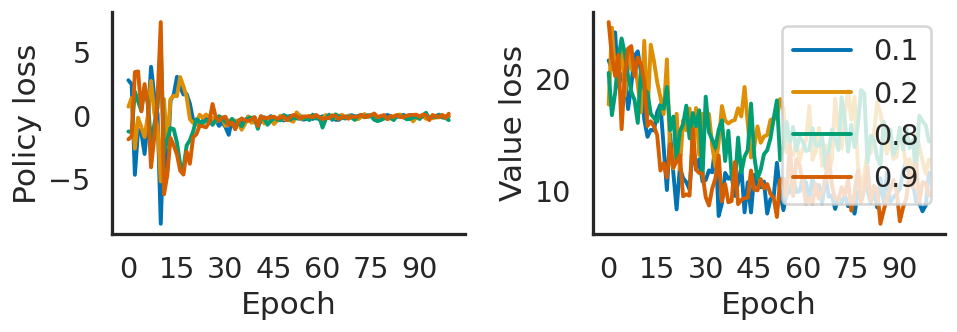

In [75]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_loss_policy.sum(2))
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(log_loss_value.sum(2))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(PROBS)
sns.despine()
f.tight_layout()

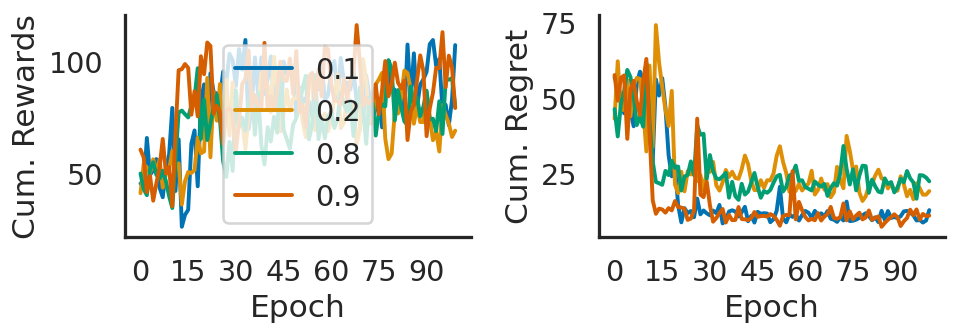

In [81]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_rewards.cumsum(3).max(3).sum(2)/(n_episodes/n_cues)) #[:n_epochs])
axes[0].set_ylabel('Cum. Rewards')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[1].plot(log_regret.cumsum(3).max(3).sum(2)/(n_episodes/n_cues))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(PROBS)
sns.despine()
f.tight_layout()

In [25]:
''' model evaluation for different banditss'''

cue = PROBS[1]
n_runs = 100
Y = task.sample(num_episodes=n_runs+1, prob=cue)

# set up the color scheme
c = np.arange(n_runs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

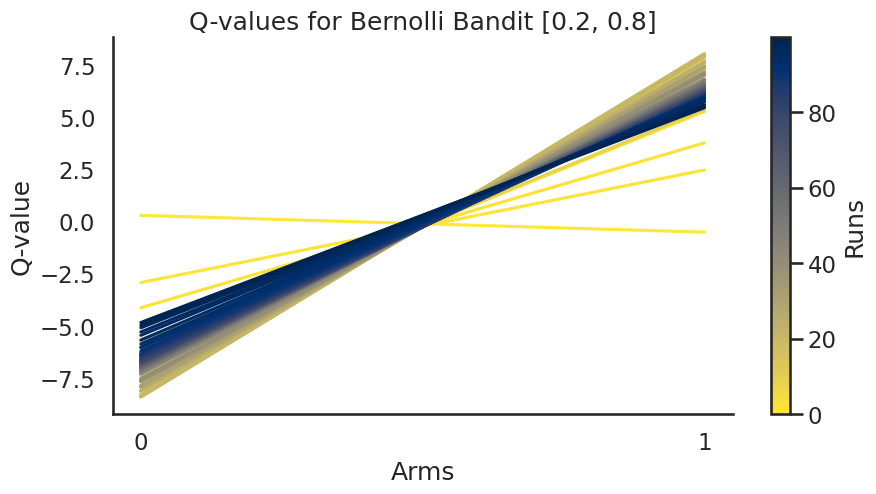

In [26]:
# run model for n_runs
agent.eval()

# set init states
h_t, c_t = agent.get_init_states()
h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
a_t = None 
r_t = Y[0].mean() 
actions, dist, values, temps, regrets = [], [], [], [], []
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

# run model
for t in range(n_runs):
    one_hot_a_t = one_hot_embedding(a_t, n_arms)
    x_t = _input(one_hot_a_t, r_t, t)
    output_t, c = agent(x_t, h_t, c_t) 
    a_t, prob_a_t, v_t, h_t, c_t = output_t
    f_t, i_t, o_t, q_t, pa_t = c
    a_t = torch.argmax(q_t)
    r_t = Y[t][a_t]
    
    regrets.append(1. - r_t)
    ax.plot(q_t.detach().numpy().T, c=cmap.to_rgba(t))
    actions.append(a_t) 
    
# format figure
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Arms',
       ylabel='Q-value',
       title= 'Q-values for Bernolli Bandit [{}, {}]'.format(cue, np.round(1.-cue, decimals=2)))
cbar = plt.colorbar(cmap, ticks=np.arange(n_runs, step=(n_runs)/5), ax=ax),
cbar[0].set_label('Runs', rotation=90)
sns.despine()
plt.show()

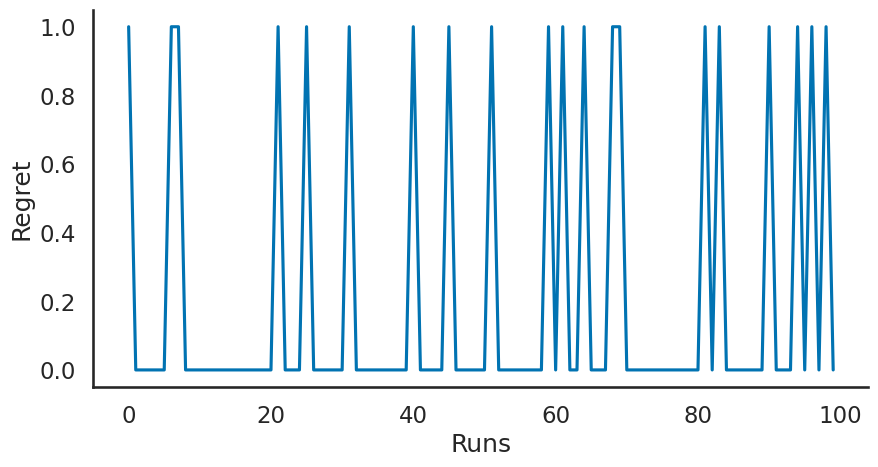

In [27]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot(regrets)
ax.set(xlabel='Runs',
       ylabel='Regret')
sns.despine()
plt.show()